# Lab 03: Pitch Classification

---
author: Yiran Hu
date: February 18, 2024
embed-resources: true
---

## Introduction

In the dynamic field of sports analytics, accurately classifying the type of pitch thrown in a baseball game represents a significant technological and analytical challenge. Major League Baseball (MLB), in its continuous pursuit of enhancing the fan experience and operational efficiency, has identified the need for a system that can automatically and instantaneously display the pitch type during live broadcasts and in-stadium displays. To address this challenge, this lab focuses on the development of a machine learning model that can predict the pitch type based on real-time data inputs. By utilizing the vast array of data available from every pitch in MLB history, including attributes such as velocity, rotation, and the batter's position, we aim to construct a K-Nearest-Neighbor (KNN) classification model. This model will leverage data from Statcast, a sophisticated tracking technology implemented in MLB stadiums that provides detailed information on pitch dynamics.

The goal of this lab is to create an innovative solution that not only improves the viewer's experience by providing immediate insights into the game's strategies but also aids broadcasters and stadium operators in delivering a more engaging and informative presentation of the game. By achieving this, we anticipate contributing to the broader field of sports analytics by offering a model that is both predictive and descriptive, thereby enriching the narrative of the game as it unfolds in real time.

## Methods

In [19]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [20]:
pitches_train = pd.read_csv("https://cs307.org/lab-03/data/pitches-train.csv")

The dataset for this lab is sourced from Statcast, accessed via the pybaseball package. It includes detailed pitch data for the pitcher Shohei Ohtani from the 2022 (training data) and 2023 (test data) MLB seasons, featuring pitch type, velocity, spin rate, horizontal and vertical movement, and the batter's stance. The training and testing data are temporally split by season, with the aim to develop a model to predict pitch types based on these features. The code block below shows what data looks like.

In [21]:
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


#### Summary Statistics

In [22]:
# Pitch Mix (Pitch Type Statistics)
pitch_group = pitches_train.groupby('pitch_name').agg('count').reset_index()
pitch_group['count'] = pitch_group['release_speed']
pitch_group['Proportion'] = pitch_group['count']/2628
pitch_group = pitch_group[['pitch_name', 'count', 'Proportion']]
pitch_group

,pitch_name,count,Proportion
0,4-Seam Fastball,718,0.273212
1,Curveball,222,0.084475
2,Cutter,233,0.088661
3,Sinker,97,0.036910
4,Slider,63,0.023973
5,Split-Finger,312,0.118721
6,Sweeper,983,0.374049


In [23]:
# Velocity by Pitch Type
velocity = pitches_train.groupby(
    'pitch_name')['release_speed'].agg('mean').reset_index()
velocity['speed_std'] = pitches_train.groupby(
    'pitch_name')['release_speed'].agg('std').reset_index()['release_speed']
velocity

,pitch_name,release_speed,speed_std
0,4-Seam Fastball,97.270613,1.699270
1,Curveball,77.679730,3.215206
2,Cutter,90.742060,2.364489
3,Sinker,97.160825,1.829592
4,Slider,85.203175,2.401543
5,Split-Finger,89.291346,1.759299
6,Sweeper,85.336419,1.862552


In [24]:
# Spin by Pitch Type
spin = pitches_train.groupby(
    'pitch_name')['release_spin_rate'].agg('mean').reset_index()
spin['spin_std'] = pitches_train.groupby('pitch_name')['release_spin_rate'].agg(
    'std').reset_index()['release_spin_rate']
spin

,pitch_name,release_spin_rate,spin_std
0,4-Seam Fastball,2217.331933,114.754683
1,Curveball,2482.666667,119.854726
2,Cutter,2378.424893,206.685887
3,Sinker,1972.747368,143.920632
4,Slider,2497.619048,78.679306
5,Split-Finger,1273.560897,221.291146
6,Sweeper,2492.172940,103.176892


#### Visualizations

This code generates a pair plot from the `pitches_train` DataFrame, coloring points by pitch type indicated in the 'pitch_name' column to illustrate the distribution of pitches across various characteristics like speed and spin. The title is set above the plot to avoid overlap, and the legend is placed outside the plot area for clarity. This visualization aids in identifying patterns and relationships between pitch characteristics, offering insights into how different types of pitches vary in their physical properties.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


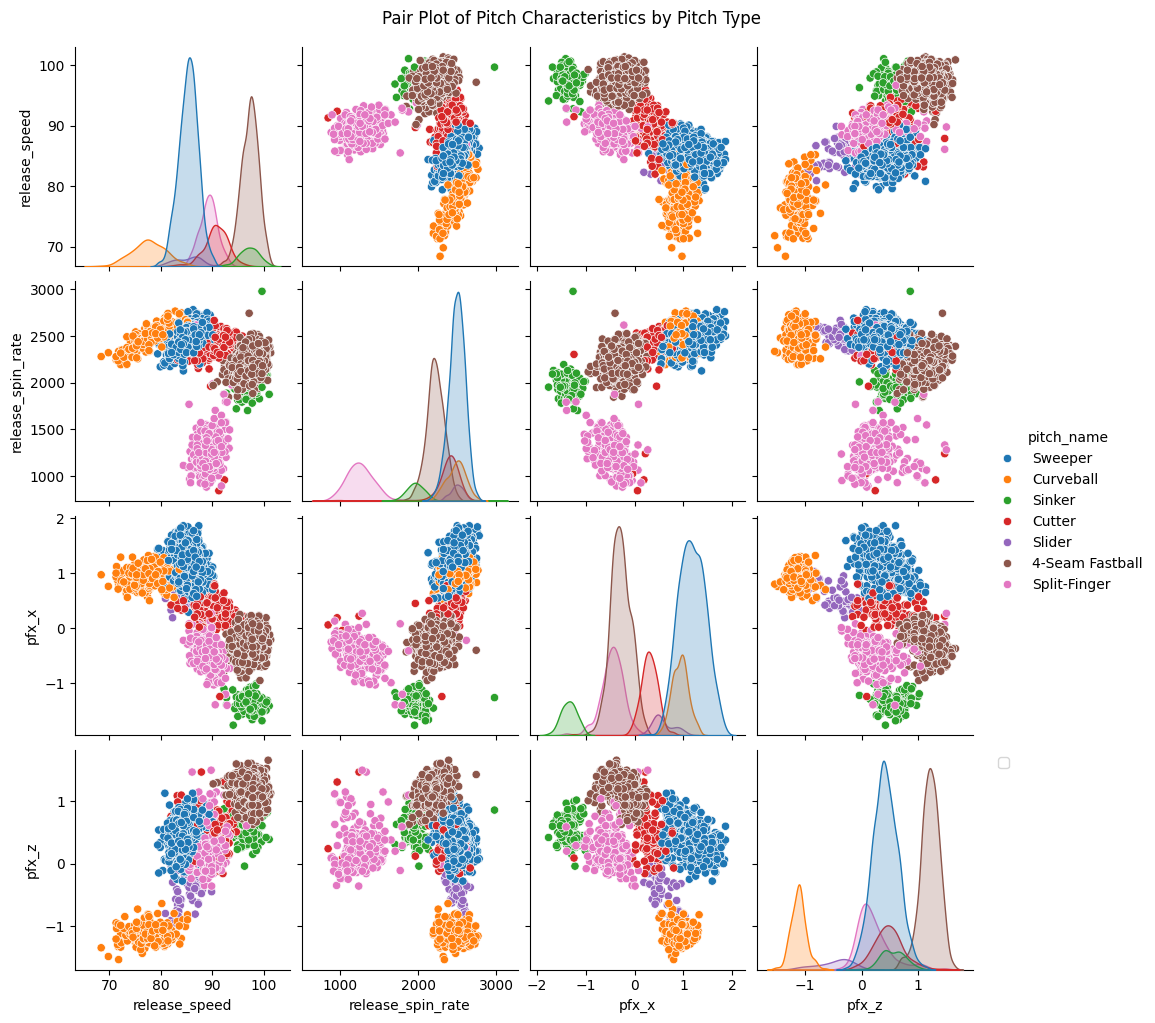

In [25]:
plot = sns.pairplot(pitches_train, hue='pitch_name')
plot.figure.suptitle(
    'Pair Plot of Pitch Characteristics by Pitch Type', y=1.02)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

The pair plot visualizes the relationships between various pitch characteristics, segregated by pitch type. Clusters indicate unique attributes for specific pitches, while overlaps suggest shared features. The diagonal histograms reveal the distribution of each characteristic within pitch types, highlighting common values and ranges. Correlations suggested by the scatter plots could inform feature importance, for example, a possible link between release speed and spin rate. Understanding the nuances of horizontal and vertical movements (pfx_x and pfx_z) is critical for pitch classification. Overall, the visualization suggests that machine learning models could potentially exploit these patterns to accurately classify pitch types, and underscores the significance of each feature in the classification process.

### Models

In [26]:
# find data types of X_train (5 features in total)
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]
X_train.dtypes

release_speed        float64
release_spin_rate    float64
pfx_x                float64
pfx_z                float64
stand                 object
dtype: object

In [27]:
# split the data into numerical and categorical features
numeric_features = X_train.select_dtypes(include=["float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

In [28]:
# define how to handle missing data and scale features for numeric and categorical features
numeric_transformer = Pipeline(
    steps=[
        ("Median Imputer", SimpleImputer(strategy="median")),
        ("Standardization", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("Modal Imputer", SimpleImputer(strategy="most_frequent")),
        ("One-Hot Encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In this lab, I processed the training data with 5 features, including both numerical and categorical variables. I applied a SimpleImputer to fill in the missing values in the numerical features, and used a OneHotEncoder to transform the categorical features. 

In [29]:
# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric Transformer", numeric_transformer, numeric_features),
        ("Categorical Transformer", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

In [30]:
# Create the pipeline
model_pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Classifier", KNeighborsClassifier())
])

I chose the K-Nearest Neighbors (KNN) model for prediction, due to its effectiveness in handling complex patterns. To optimize the model, I conducted hyperparameter tuning through grid search, focusing on the number of neighbors, weight strategies, and distance metrics.

In [31]:
# define the parameter grid for grid search
param_grid = {
    "Classifier__n_neighbors": range(1, 20),  # set the range of k from 1 to 19
    # define how the neighbors contribute, equally or have different weights based on distance
    "Classifier__weights": ["uniform", "distance"],
    # distance metrics to be used for calculating the proximity between data points
    "Classifier__metric": ["euclidean", "manhattan", "chebyshev"]
}

In [32]:
# setup grid search with cross-validation
grid_search = GridSearchCV(
    model_pipeline, param_grid, cv=5, scoring="accuracy")

In [33]:
# fit models
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('Numeric '
                                                                         'Transformer',
                                                                         Pipeline(steps=[('Median '
                                                                                          'Imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('Standardization',
                                                                                          StandardScaler())]),
                                                                         Index(['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'], dtype='object')),
                                                                        ('Categorical '
                                                                         'Transformer',
                                                                         Pipeline(steps=[('Mod...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('One-Hot '
                                                                                          'Encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['stand'], dtype='object'))])),
                                       ('Classifier', KNeighborsClassifier())]),
             param_grid={'Classifier__metric': ['euclidean', 'manhattan',
                                                'chebyshev'],
                         'Classifier__n_neighbors': range(1, 20),
                         'Classifier__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [34]:
# save models
dump(grid_search, "pitch-classifier.joblib")

['pitch-classifier.joblib']

## Results

In [35]:
print("Best parameters found:", grid_search.best_params_)
print("accuracy:", grid_search.best_score_)

Best parameters found: {'Classifier__metric': 'manhattan', 'Classifier__n_neighbors': 19, 'Classifier__weights': 'distance'}
accuracy: 0.974500814774579


To ensure the robustness of our model, we conducted a comprehensive grid search to optimize the hyperparameters of our K-Nearest Neighbors classifier, aimed at predicting MLB pitch types. The grid search, considering various combinations of metrics, neighbor counts, and weight strategies, revealed that a 'manhattan' distance metric, coupled with a relatively high neighbor count of k=19, and distance-based weighting, yielded the most accurate results. These parameters were meticulously selected to enhance the model's ability to generalize across unseen data, achieving an outstanding accuracy of approximately 97.45%. 

## Discussion

In developing a pitch classification system that is scalable across the entire MLB, we've taken into account the diversity of pitching styles among hundreds of players. A robust model must be trained on a dataset representative of this variety to accommodate any pitcher who might play, including those making their MLB debut. Continuous data integration and model retraining are part of our strategy to ensure the model remains current with players' evolving techniques and the introduction of new pitches.

Our approach to model training uses historical data from 2022, with the subsequent year's data serving as a test set to simulate real-world application for future games. While this strategy aligns with the predictive nature of our objectives, it introduces the challenge of accounting for changes in pitchers' behavior, such as the adoption of new pitches or modifications to existing ones during the off-season. These changes could lead to a discrepancy between the model's performance on past data and its effectiveness in a live setting.

The real-time capability of the classifier is another critical aspect. The KNN algorithm, while accurate, may not be the most efficient for real-time predictions due to its computational demands during the querying phase. In a live MLB game setting, the classification of a pitch type must occur almost instantaneously. Therefore, we need to more efficient algorithms and optimization techniques that can deliver the necessary speed without compromising the model's accuracy, ensuring the system's viability for real-time broadcast and analysis.

### Conclusion

In this lab, I used Python's sklearn Pipeline and GridSearchCV functionalities to refine the use of the K-Nearest Neighbors (KNN) algorithm for MLB pitch classification. This methodological enhancement facilitated the construction of a sophisticated model capable of predicting pitch types from a comprehensive dataset provided by Statcast. While the model showcased promising accuracy in classifying pitch types based on real-time game data, it is essential to acknowledge the dynamic nature of the sport, where pitchers frequently adapt and evolve their techniques. Recognizing this, the implementation of such a model in a live game scenario must be done with consideration for its adaptability and the need for ongoing updates to maintain its relevance. Future work will necessitate a vigilant approach to model maintenance, ensuring it evolves in tandem with the sport, thereby maintaining the integrity and utility of the system within the ever-changing landscape of professional baseball.